In [53]:
import xarray as xr
import numpy as np
import xesmf
import matplotlib.pyplot as plt
import matplotlib as mpl
# Any import of metpy will activate the accessors
import glob
import pandas as pd
import scipy
import metpy
from metpy.interpolate import interpolate_to_points
import cmocean
import cartopy
import cartopy.crs as ccrs
import math
import cmaps
import cftime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from matplotlib.transforms import Affine2D
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
import scipy.sparse as sps
import warnings

# Define flooding functions

In [54]:
def ffill_one_point_northlat(arr):
    #Forward fill only the first NaN value in each row.
    mask=xr.where(np.isnan(arr),0,1)
    fmask=(mask + mask.shift(lat=1))/2
    farr = xr.where(fmask==0.5, arr.shift(lat=1),arr)
    return farr

def ffill_one_point_southlat(arr):
    #Forward fill only the first NaN value in each row.
    mask=xr.where(np.isnan(arr),0,1)
    fmask=(mask + mask.shift(lat=-1))/2
    farr = xr.where(fmask==0.5, arr.shift(lat=-1),arr)
    return farr

def ffill_one_point_depth(arr):
    #Forward fill only the first NaN value in each row.
    mask=xr.where(np.isnan(arr),0,1)
    fmask=(mask + mask.shift(depth=1))/2
    farr = xr.where(fmask==0.5, arr.shift(depth=1),arr)
    return farr

# Define variables and paths

In [55]:
var='Temp'
varN='thetao'
varG='thetao'
varA='T068'
units='degreeC'

outdir='/data/ghervieux/NG_NMS_NN'

# Read GLORYS Temperature, extract Surface and 01/01/1993 array.

In [56]:
# Read temperature
def preprocess(ds):
    return ds.sel(longitude=slice(239,241)).\
              sel(latitude=slice(33.2,34.8)).\
              sel(depth=slice(0,300))
datadir="/Projects/Air_Sea/jscott/GLORYS/Monthlies"
fileg=f'{datadir}/{varG}.mon.mean.1993-2019.CalCS.nc'
DG=xr.open_dataset(fileg).pipe(preprocess)
DG=DG.sel(time=slice('1993-01-01','2019-12-31'))
DG=DG.isel(time=1)
DG=DG.isel(depth=0)
DG=DG[varG]
DG=DG.load()

# Define grid input for interpolation module
DDD=DG
DDD=DDD.rename({'longitude':'lon','latitude':'lat'})

# Define landseamask and build lon2d: Xg and lat2d: Yg
landseamaskG=xr.where(np.isnan(DG)==False,1,np.nan)
Xg,Yg=np.meshgrid(landseamaskG.longitude,landseamaskG.latitude)

# Read NEP Temperature, extract surface and 01/01/1993 array.

In [57]:
# Define grid input for interpolation module
# Get right LON, LAT
DD=xr.open_dataset('/scratch/jliu/NEP10k/NEP_ocean_static_nomask.nc')
DD=DD.isel(xh=slice(230,246)).isel(yh=slice(195,210))
deptho=DD['deptho']
DD=DD[['deptho','geolon','geolat']]
DD=DD.rename({'geolon':'lon','geolat':'lat'})

# Read temperature
filen=f'/scratch/jliu/NEP10k/ocean_monthly_z.199301-201912.{varN}.nc'
DN=xr.open_dataset(filen)
DN=DN.sel(time=slice('1993-01-01','2019-12-31'))
DN=DN.isel(time=1)
DN=DN.isel(xh=slice(230,246)).isel(yh=slice(195,210))
DN=DN.assign_coords({'longitude':DD.lon,'latitude':DD.lat})
DN=DN.isel(z_l=0)
DN=DN[varN]
DN=DN.load()

# Define landseamask
landseamaskN=xr.where(np.isnan(DN)==False,1,np.nan)

# PnB define longitude and latitude of the 7 stations.

In [58]:
dep=np.arange(0,100,1)


lonC=[240.15928426, 240.13757992, 240.11724596, 240.09357516,\
       240.07200043, 240.05083674, 239.97781105]
latC=[34.38953362, 34.34343689, 34.29852723, 34.25117429, 34.20348362,\
       34.15821721, 34.08495211]

latC=xr.DataArray(latC,dims=['npts'])
lonC=xr.DataArray(lonC,dims=['npts'])

# create grid output
lonCC=xr.DataArray(lonC,dims=['lon'])
latCC=xr.DataArray(latC,dims=['lat'])
ds_out = xr.Dataset(coords=dict(lat=latCC,lon=lonCC))

#########
## test 1: No Flooding, NN= Nearest Neighboor Interpolation 
#########

In [59]:
#########
### GLORYS
######### 

regridder_G_NN = xesmf.Regridder(DDD, ds_out, "nearest_s2d")
DGptsi = regridder_G_NN(DG)
#---
DGdpts =np.zeros((len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['npts'],
        coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[i]=DGptsi[i,i].values

#######
### NEP
#######

regridder_N_NN = xesmf.Regridder(DD, ds_out, "nearest_s2d")
DNptsi = regridder_N_NN(DN)
#---
DNdpts =np.zeros((len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['npts'],
          coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[i]=DNptsi[i,i].values

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# Get points involved in the interpolation scheme

In [60]:
##########
# Define Interpolation Weights
##########
weights_G = regridder_G_NN.weights
pts_G_NN=xr.zeros_like(DG).expand_dims({'npts':len(lonC)}).copy()
for outj in range(0,len(lonC)):
   idlat,idlon=np.where(weights_G[outj*(1+len(lonC)),:].data.todense().\
                  reshape((len(DG.latitude),len(DG.longitude)))==1)
   pts_G_NN[outj,idlat[:],idlon[:]]=1


weights_N = regridder_N_NN.weights
pts_N_NN=xr.zeros_like(DN.expand_dims({'npts':len(lonC)}).copy())
for outj in range(0,len(lonC)):
   idlat,idlon=np.where(weights_N[outj*(1+len(lonC)),:].data.todense().\
                  reshape((len(DN.yh),len(DN.xh)))==1)
   pts_N_NN[outj,idlat[:],idlon[:]]=1

# create markers

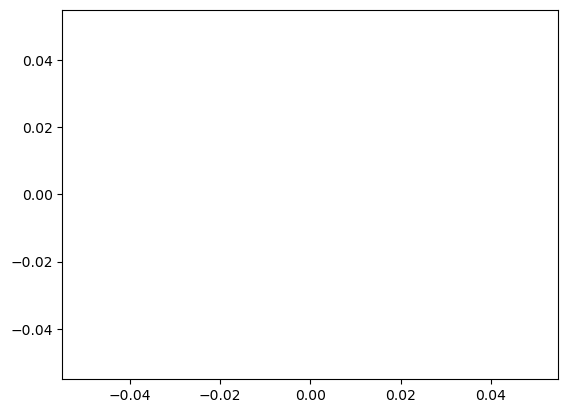

In [61]:

###
colors=['g','slategrey','k','royalblue','teal','darkviolet','olive']
markers=['s','X','P','o','v','^','*']
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(markers[i], colors[i]) for i in range(len(markers))]
labels = ['R1','R2','R3','R4','R5','R6','R7']
# Choose a colormap
cmap = cmocean.cm.thermal

# PLOT test 1 GLORYS

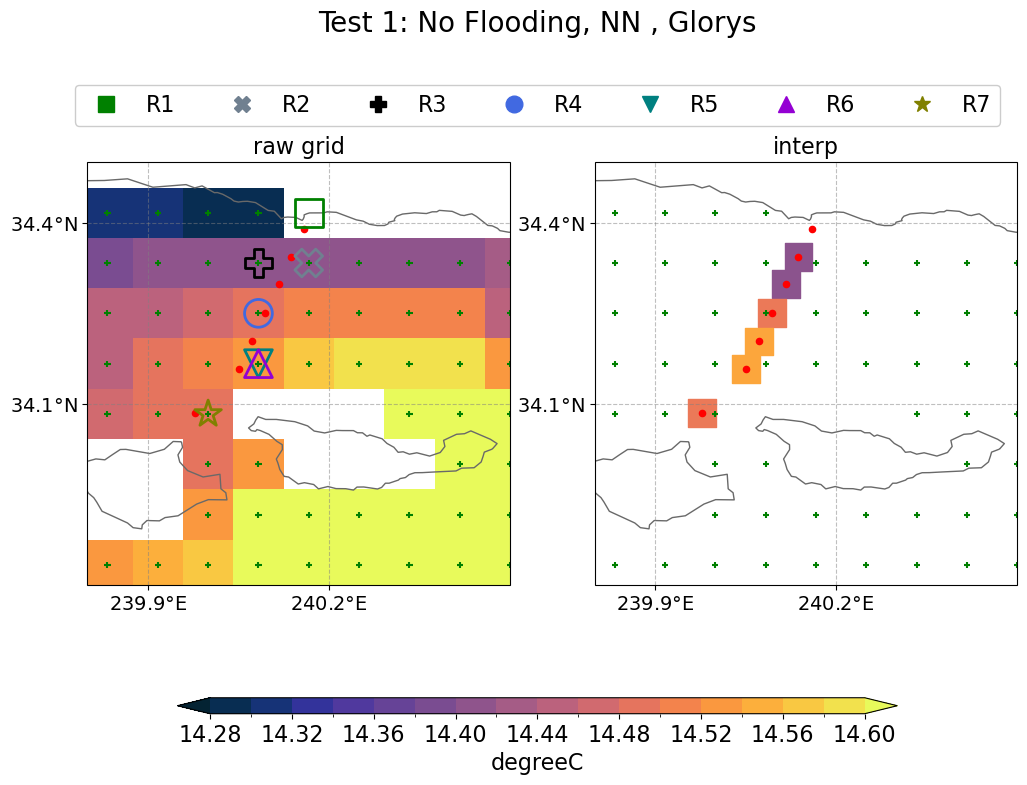

In [62]:
#####
levels = np.arange(14.28,14.6,0.02)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
## raw grid
cc=DG.plot(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False) # plot GLORYS temperature
for outj in range(0,len(lonC)):                                  # plot interpolation pts 
  data=xr.where(pts_G_NN[outj,:,:]==1,400,np.nan)
  axs[0].scatter(Xg,Yg,s=data, marker=markers[outj],c='None',ec=colors[outj],zorder=50,lw=2.,transform=ccrs.PlateCarree())
axs[0].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree()) # plot GLORYS t-points 
for ic in range(len(lonC)): # plot PnB obs location
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DGdpts.data,cmap=cmap,norm=norm,marker='s',s=400) # plot GLORYS temperature interpolated on the PnB stations
axs[1].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree()) # plot GLORYS t-points 
for ic in range(len(lonC)): # plot PnB obs location
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_yticks([34.1,34.4]) 
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
  axs[ix].set_xticks([-120.1,-119.8]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
###
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 1: No Flooding, NN , Glorys',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_G_test1.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT test1 NEP

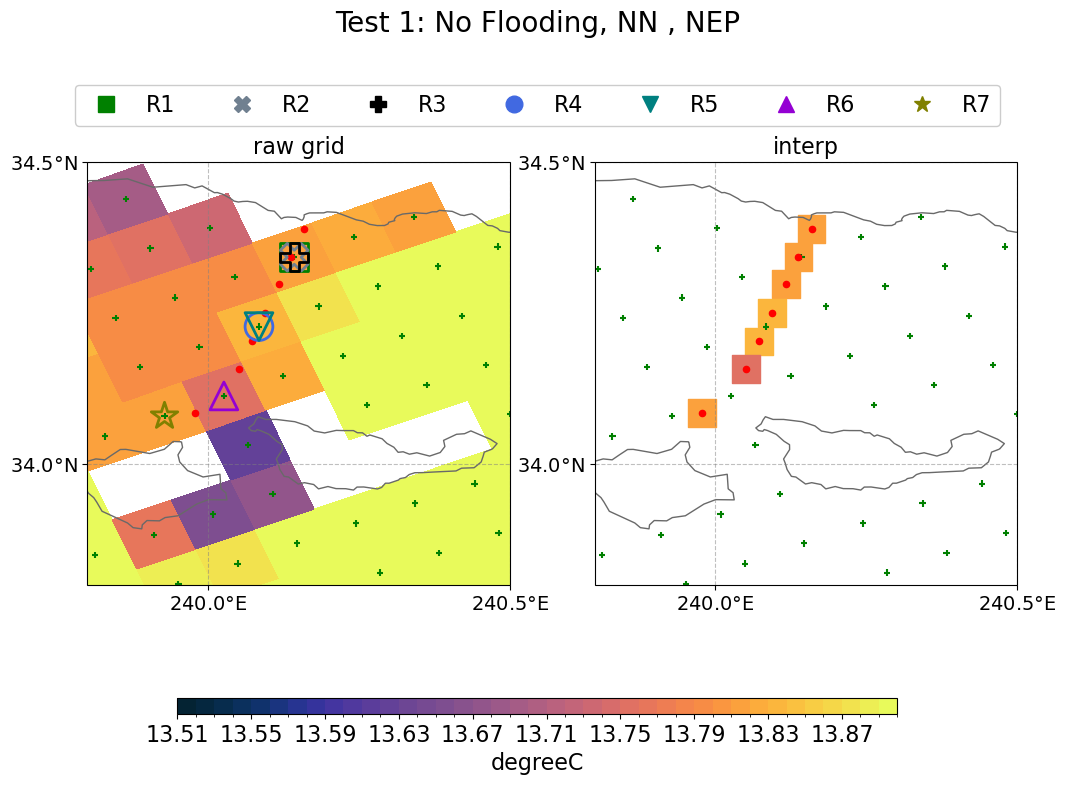

In [63]:

#####
levels = np.arange(13.51,13.9,0.01)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
##########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
for outj in range(0,len(lonC)):
  data=xr.where(pts_N_NN[outj,:,:]==1,400,np.nan)
  axs[0].scatter(DD.lon,DD.lat,s=data, marker=markers[outj],c='None',ec=colors[outj],lw=2.,zorder=50, transform=ccrs.PlateCarree())
cc=axs[0].pcolormesh(DN.longitude.data,DN.latitude.data,DN.data,cmap=cmap,norm=norm)
axs[0].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DNdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_xticks([-120,-119.5]) 
  axs[ix].set_yticks([34,34.5]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
##
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 1: No Flooding, NN , NEP',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_N_test1.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT Taylor diagram

In [ ]:
  xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
  xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
  xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
  yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))
  # Reference dataset
  dataC=obs.data.flatten()[yyy]
  # Generate models
  m1C = glo.data.flatten()[yyy]  # Model 1
  m2C = nep.data.flatten()[yyy]  # Model 2

In [ ]:
  samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

  fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(6, 6),num=2,clear=True)
  dia = TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                        srange=(0., 1.5))

  colors = ['red','green','blue']
  labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
  # Add the models to Taylor diagram
  for i, (stddev, corrcoef) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                       marker='*', ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=labels[i])
  # Add grid
  dia.add_grid()
  axs.axis('off')
  # Add a figure legend
  fig.legend(dia.samplePoints,
              [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, loc='upper right',\
                       bbox_to_anchor=(0.98,0.94), prop={'size': 14})
  plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
                ha='center',fontsize=14,rotation=0)
  plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
                va='center',fontsize=14,rotation=315)
  plt.text(0.4,0.96,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
                rotation=0,ha='center',fontsize=14)
  plt.suptitle(f'{var}, {cruise} Line {iline}, JAS',fontsize=20)
  outfile=f'PLOTS/{cruise}_JAS_{var}_line{iline}_TaylorDiagram{suffixe}.png'
  plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT Scatter 

In [ ]:
  rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
  rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
  cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
  cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

  fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)
  plt.subplots_adjust(bottom=0.11, right=0.9,\
        top=0.85,hspace=0.1,wspace=0.4)

  scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
  scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
  axs[0].text(0.02, 0.95,f'N={len(xxx1)}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
  axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
  axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
                rotation='horizontal',fontsize=12)
  axs[1].text(0.02, 0.95,f'N={len(xxx2)}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
  axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)
  axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
                rotation='horizontal',fontsize=12)

  for i in range(len(axs)):
    axs[i].set_ylim(5,24)
    axs[i].set_xlim(5,24)
    axs[i].grid()
    axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
    axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
    axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
    axs[i].set_xlabel(f'{cruise}: Temp ($\degree$C)',fontsize=18)

  axs[0].set_ylabel('GLORYS 1/12$\degree$: Temp ($\degree$C)',fontsize=18)
  axs[1].set_ylabel('NEP 10k: Temp ($\degree$C)',fontsize=18)

  plt.suptitle(f'{cruise} No Flooding, NN',fontsize=20)
  outfile=f'PLOTS/{cruise}_Scatter_test1.png'
  plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 2: No Flooding, bilinear Interpolation 
#########

# Interpolation via xesmf module

In [64]:

### GLORYS
##### Interp H
lonCC=xr.DataArray(lonC,dims=['lon'])
latCC=xr.DataArray(latC,dims=['lat'])
ds_out = xr.Dataset(coords=dict(lat=latCC,lon=lonCC))
regridder_G_bi = xesmf.Regridder(DDD, ds_out, "bilinear")
DGptsi = regridder_G_bi(DG)
#---
DGdpts =np.zeros((len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['npts'],
        coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[i]=DGptsi[i,i].values

#####
### NEP
##### Interp H
lonCC=xr.DataArray(lonC,dims=['lon'])
latCC=xr.DataArray(latC,dims=['lat'])
ds_out = xr.Dataset(coords=dict(lat=latCC,lon=lonCC))
regridder_N_bi = xesmf.Regridder(DD, ds_out, "bilinear")
DNptsi = regridder_N_bi(DN)
#---
DNdpts =np.zeros((len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['npts'],
          coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[i]=DNptsi[i,i].values

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# Get points involved in the interpolation scheme

In [65]:
##########
# Define Interpolation Weights
##########
weights_G = regridder_G_bi.weights
pts_G_bi=xr.zeros_like(DG).expand_dims({'npts':len(lonC)}).copy()
for outj in range(0,len(lonC)):
   idlat,idlon=np.where(weights_G[outj*(1+len(lonC)),:].data.todense().\
                  reshape((len(DG.latitude),len(DG.longitude)))>0)
   pts_G_bi[outj,idlat[:],idlon[:]]=1


weights_N = regridder_N_bi.weights
pts_N_bi=xr.zeros_like(DN.expand_dims({'npts':len(lonC)}).copy())
for outj in range(0,len(lonC)):
   idlat,idlon=np.where(weights_N[outj*(1+len(lonC)),:].data.todense().\
                  reshape((len(DN.yh),len(DN.xh)))>0)
   pts_N_bi[outj,idlat[:],idlon[:]]=1

# PLOT test2 GLORYS

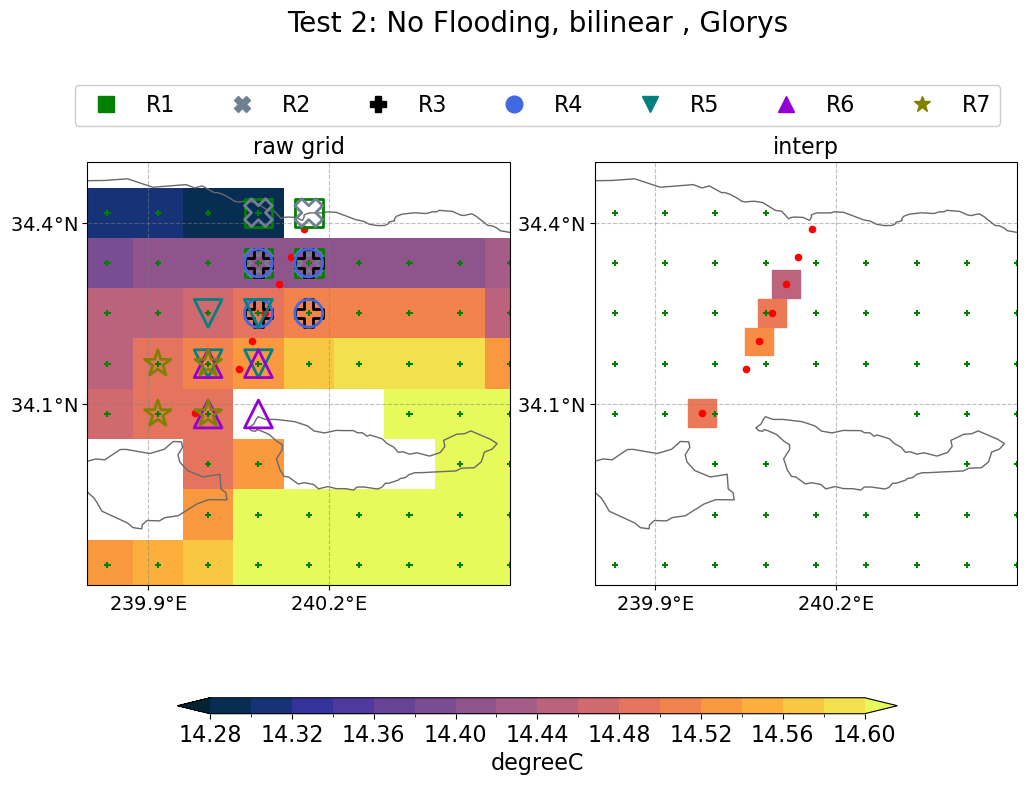

In [66]:
#####
levels = np.arange(14.28,14.6,0.02)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
## GLORYS
cc=DG.plot(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False)
for outj in range(0,len(lonC)):
  data=xr.where(pts_G_bi[outj,:,:]==1,400,np.nan)
  axs[0].scatter(Xg,Yg,s=data, marker=markers[outj],c='None',ec=colors[outj],zorder=50,lw=2 , transform=ccrs.PlateCarree())
axs[0].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DGdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_yticks([34.1,34.4]) 
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
  axs[ix].set_xticks([-120.1,-119.8]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
###
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 2: No Flooding, bilinear , Glorys',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_G_test2.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT test 2 NEP

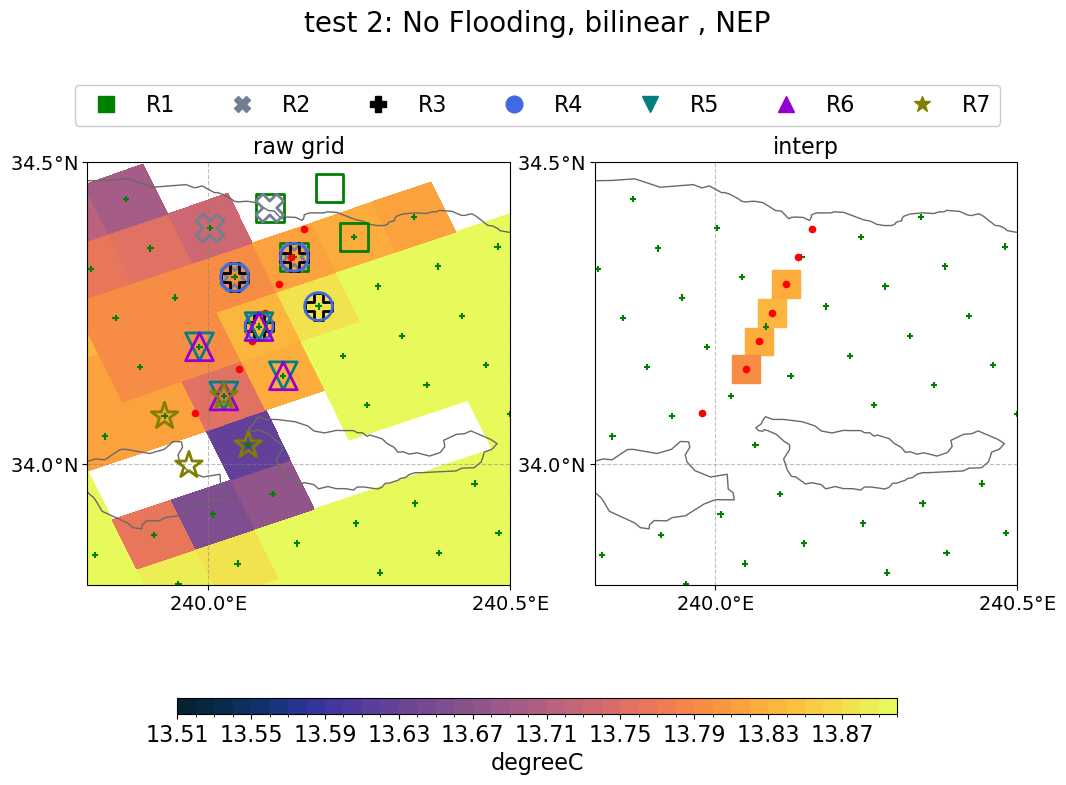

In [67]:

#####
levels = np.arange(13.51,13.9,0.01)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
for outj in range(0,len(lonC)):
  data=xr.where(pts_N_bi[outj,:,:]==1,400,np.nan)
  axs[0].scatter(DD.lon,DD.lat,s=data, marker=markers[outj],c='None',ec=colors[outj],zorder=50,lw=2 ,transform=ccrs.PlateCarree())
cc=axs[0].pcolormesh(DN.longitude.data,DN.latitude.data,DN.data,cmap=cmap,norm=norm)
axs[0].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DNdpts.data,norm=norm,cmap=cmap,marker='s',s=400)
axs[1].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_xticks([-120,-119.5]) 
  axs[ix].set_yticks([34,34.5]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
##
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('test 2: No Flooding, bilinear , NEP', fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_N_test2.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 3: Southward Flooding, NN= Nearest Neighboor Interpolation 
#########

# Southward Flooding

In [68]:
# GLORYS
DGs=ffill_one_point_southlat(DG.rename({'latitude':'lat'}))
DGs=DGs.rename({'lat':'latitude'})

# NEP
DNs=ffill_one_point_southlat(DN.rename({'yh':'lat'}))
DNs=DNs.rename({'lat':'yh'})


# Interpolation via xesmf module

In [69]:
#########
### GLORYS
##### Interp H

DGptsi = regridder_G_NN(DGs)
#---
DGdpts =np.zeros((len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['npts'],
        coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[i]=DGptsi[i,i].values

#######
### NEP
##### Interp H

DNptsi = regridder_N_NN(DNs)
#---
DNdpts =np.zeros((len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['npts'],
          coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[i]=DNptsi[i,i].values

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT test3 GLORYS

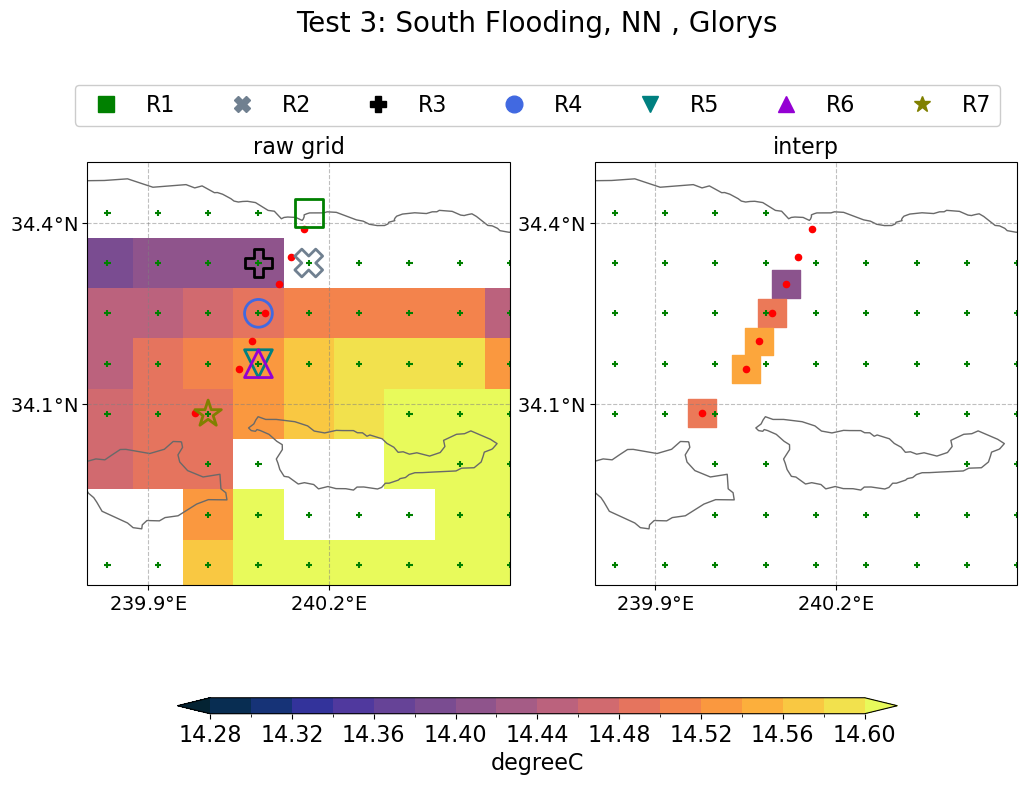

In [70]:
#####
levels = np.arange(14.28,14.6,0.02)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
## 
cc=DGs.plot(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False)
for outj in range(0,len(lonC)):
  data=xr.where(pts_G_NN[outj,:,:]==1,400,np.nan)
  axs[0].scatter(Xg,Yg,s=data, marker=markers[outj],c='None',ec=colors[outj],zorder=50,lw=2.,transform=ccrs.PlateCarree())
axs[0].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DGdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_yticks([34.1,34.4]) 
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
  axs[ix].set_xticks([-120.1,-119.8]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
###
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 3: South Flooding, NN , Glorys',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_G_test3.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT test 3 NEP

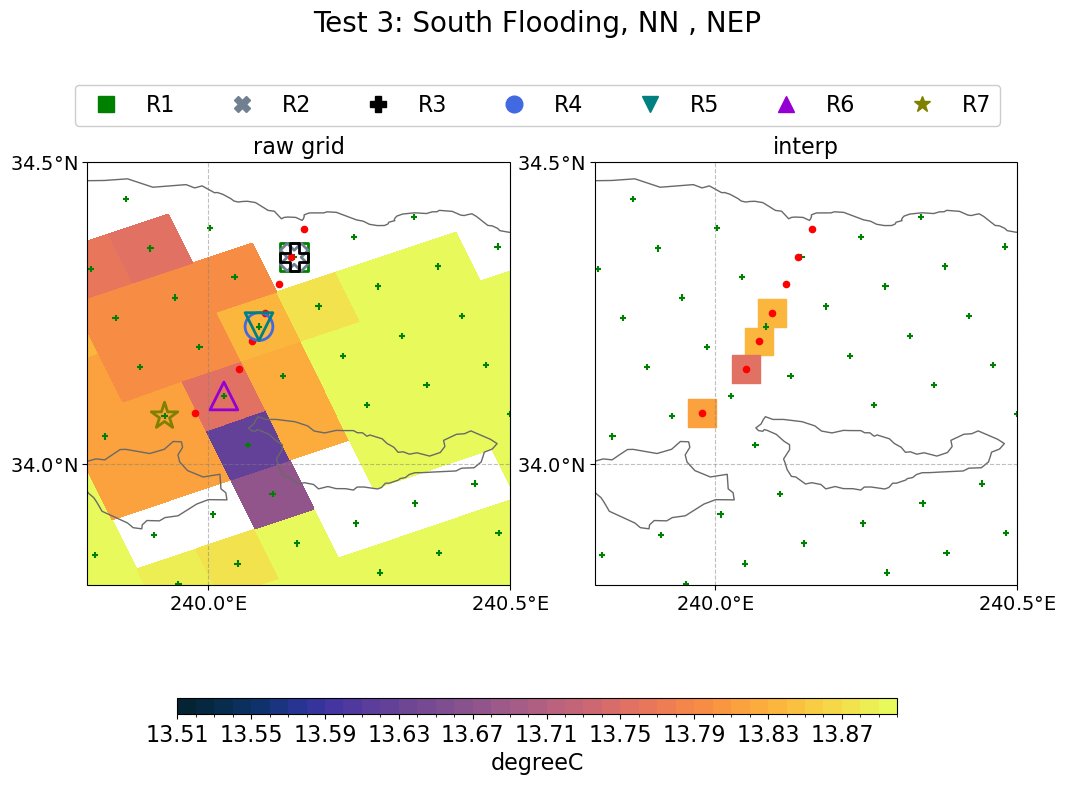

In [71]:

#####
levels = np.arange(13.51,13.9,0.01)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
##########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
for outj in range(0,len(lonC)):
  data=xr.where(pts_N_NN[outj,:,:]==1,400,np.nan)
  axs[0].scatter(DD.lon,DD.lat,s=data, marker=markers[outj],c='None',ec=colors[outj],lw=2.,zorder=50, transform=ccrs.PlateCarree())
cc=axs[0].pcolormesh(DN.longitude.data,DN.latitude.data,DNs.data,cmap=cmap,norm=norm)
axs[0].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DNdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_xticks([-120,-119.5]) 
  axs[ix].set_yticks([34,34.5]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
##
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 3: South Flooding, NN , NEP',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_N_test3.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 4: Southward Flooding, bilinear Interpolation 
#########

# Interpolation via xesmf module

In [72]:
### GLORYS
##### Interp H

DGptsi = regridder_G_bi(DGs)
#---
DGdpts =np.zeros((len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['npts'],
        coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[i]=DGptsi[i,i].values

#####
### NEP
##### Interp H

DNptsi = regridder_N_bi(DNs)
#---
DNdpts =np.zeros((len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['npts'],
          coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[i]=DNptsi[i,i].values

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT test 4 GLORYS

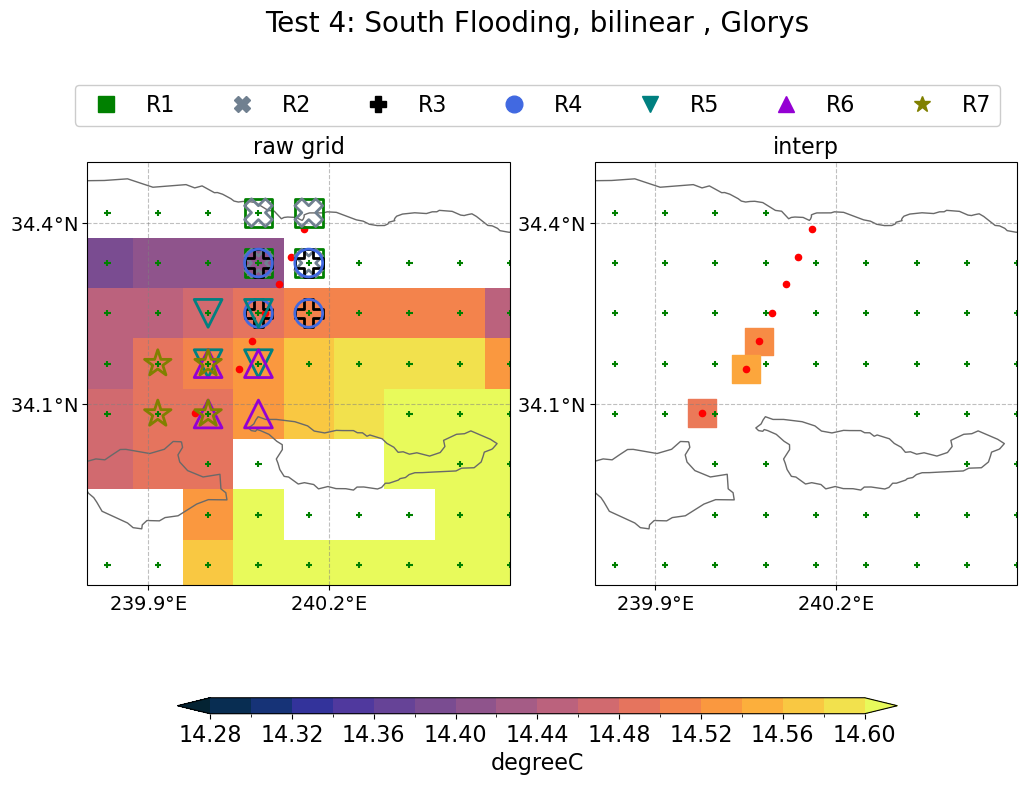

In [73]:
#####
levels = np.arange(14.28,14.6,0.02)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
## 
cc=DGs.plot(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False)
for outj in range(0,len(lonC)):
  data=xr.where(pts_G_bi[outj,:,:]==1,400,np.nan)
  axs[0].scatter(Xg,Yg,s=data, marker=markers[outj],c='None',ec=colors[outj],zorder=50,lw=2.,transform=ccrs.PlateCarree())
axs[0].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DGdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_yticks([34.1,34.4]) 
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
  axs[ix].set_xticks([-120.1,-119.8]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
###
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 4: South Flooding, bilinear , Glorys',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_G_test4.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT test 4 NEP

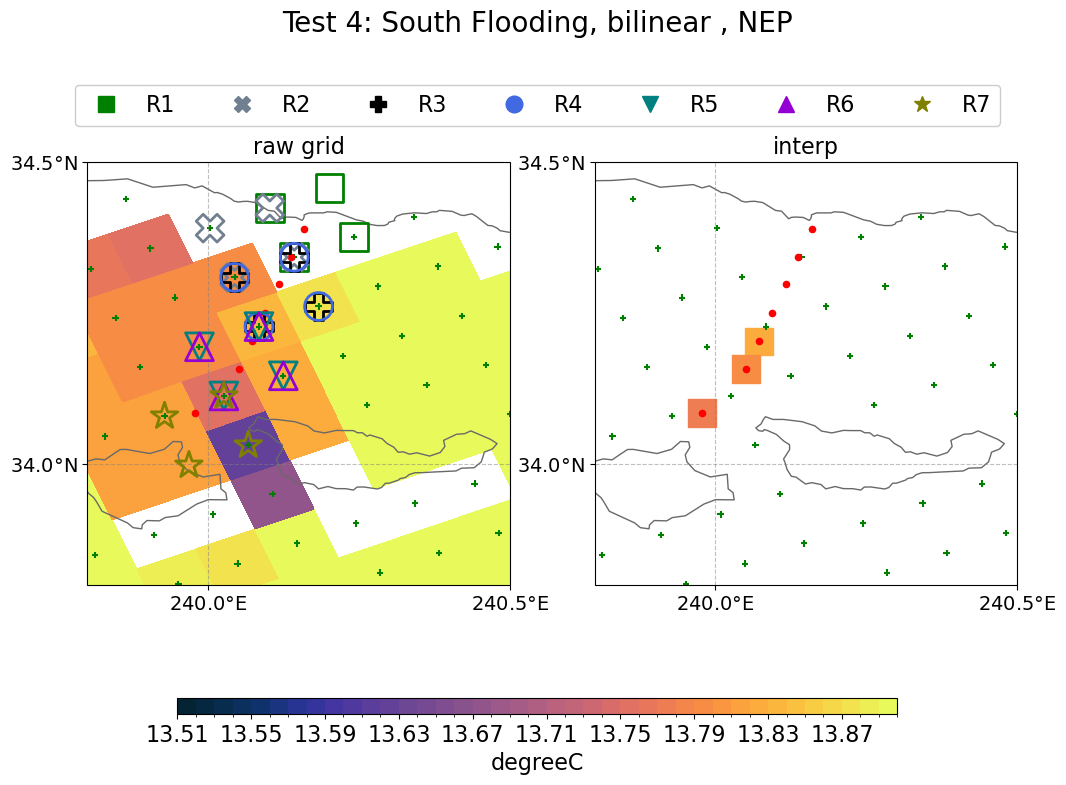

In [74]:

#####
levels = np.arange(13.51,13.9,0.01)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
##########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
for outj in range(0,len(lonC)):
  data=xr.where(pts_N_bi[outj,:,:]==1,400,np.nan)
  axs[0].scatter(DD.lon,DD.lat,s=data, marker=markers[outj],c='None',ec=colors[outj],lw=2.,zorder=50, transform=ccrs.PlateCarree())
cc=axs[0].pcolormesh(DN.longitude.data,DN.latitude.data,DNs.data,cmap=cmap,norm=norm)
axs[0].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DNdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_xticks([-120,-119.5]) 
  axs[ix].set_yticks([34,34.5]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
##
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 4: South Flooding, bilinear , NEP',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_N_test4.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 5: Northward Flooding, NN= Nearest Neighboor Interpolation 
#########

# Northward Flooding

In [75]:
# GLORYS
DGn=ffill_one_point_northlat(DG.rename({'latitude':'lat'}))
DGn=DGn.rename({'lat':'latitude'})

# NEP
DNn=ffill_one_point_northlat(DN.rename({'yh':'lat'}))
DNn=DNn.rename({'lat':'yh'})

# Interpolation via xesmf module

In [76]:
#########
### GLORYS
##### Interp H

DGptsi = regridder_G_NN(DGn)
#---
DGdpts =np.zeros((len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['npts'],
        coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[i]=DGptsi[i,i].values

#######
### NEP
##### Interp H

DNptsi = regridder_N_NN(DNn)
#---
DNdpts =np.zeros((len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['npts'],
          coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[i]=DNptsi[i,i].values

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT test5 GLORYS

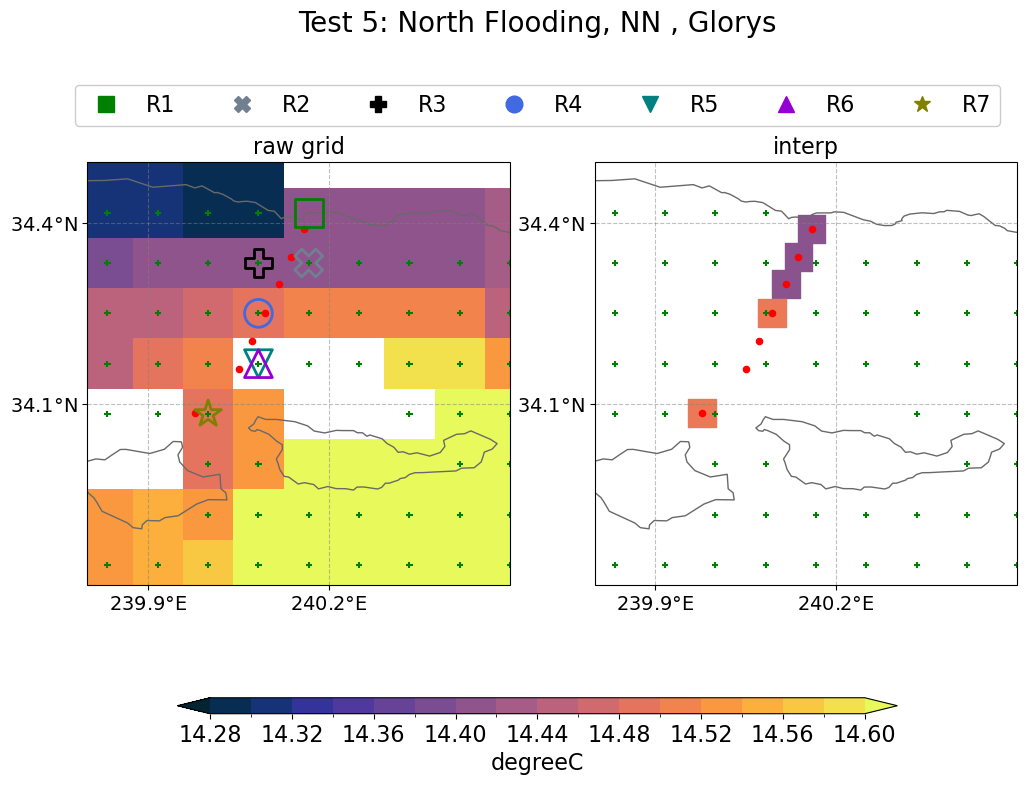

In [77]:
#####
levels = np.arange(14.28,14.6,0.02)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
## 
cc=DGn.plot(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False)
for outj in range(0,len(lonC)):
  data=xr.where(pts_G_NN[outj,:,:]==1,400,np.nan)
  axs[0].scatter(Xg,Yg,s=data, marker=markers[outj],c='None',ec=colors[outj],zorder=50,lw=2.,transform=ccrs.PlateCarree())
axs[0].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DGdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_yticks([34.1,34.4]) 
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
  axs[ix].set_xticks([-120.1,-119.8]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
###
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 5: North Flooding, NN , Glorys',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_G_test5.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT test5 NEP

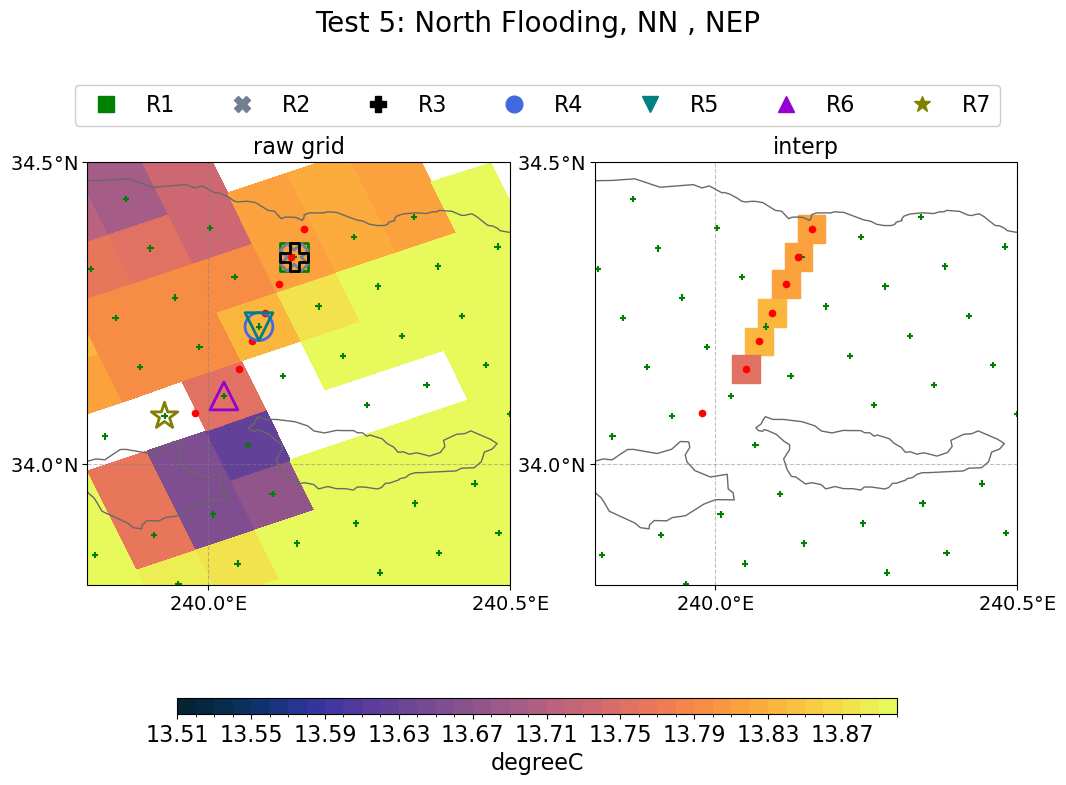

In [78]:

#####
levels = np.arange(13.51,13.9,0.01)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
##########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
for outj in range(0,len(lonC)):
  data=xr.where(pts_N_NN[outj,:,:]==1,400,np.nan)
  axs[0].scatter(DD.lon,DD.lat,s=data, marker=markers[outj],c='None',ec=colors[outj],lw=2.,zorder=50, transform=ccrs.PlateCarree())
cc=axs[0].pcolormesh(DN.longitude.data,DN.latitude.data,DNn.data,cmap=cmap,norm=norm)
axs[0].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DNdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_xticks([-120,-119.5]) 
  axs[ix].set_yticks([34,34.5]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
##
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 5: North Flooding, NN , NEP',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_N_test5.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 7: Northward Flooding, bilinear Interpolation 
#########

# Interpolation via xesmf module

In [79]:
### GLORYS
##### Interp H

DGptsi = regridder_G_bi(DGn)
#---
DGdpts =np.zeros((len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['npts'],
        coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[i]=DGptsi[i,i].values

#####
### NEP
##### Interp H

DNptsi = regridder_N_bi(DNn)
#---
DNdpts =np.zeros((len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['npts'],
          coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[i]=DNptsi[i,i].values

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT test6 GLORYS

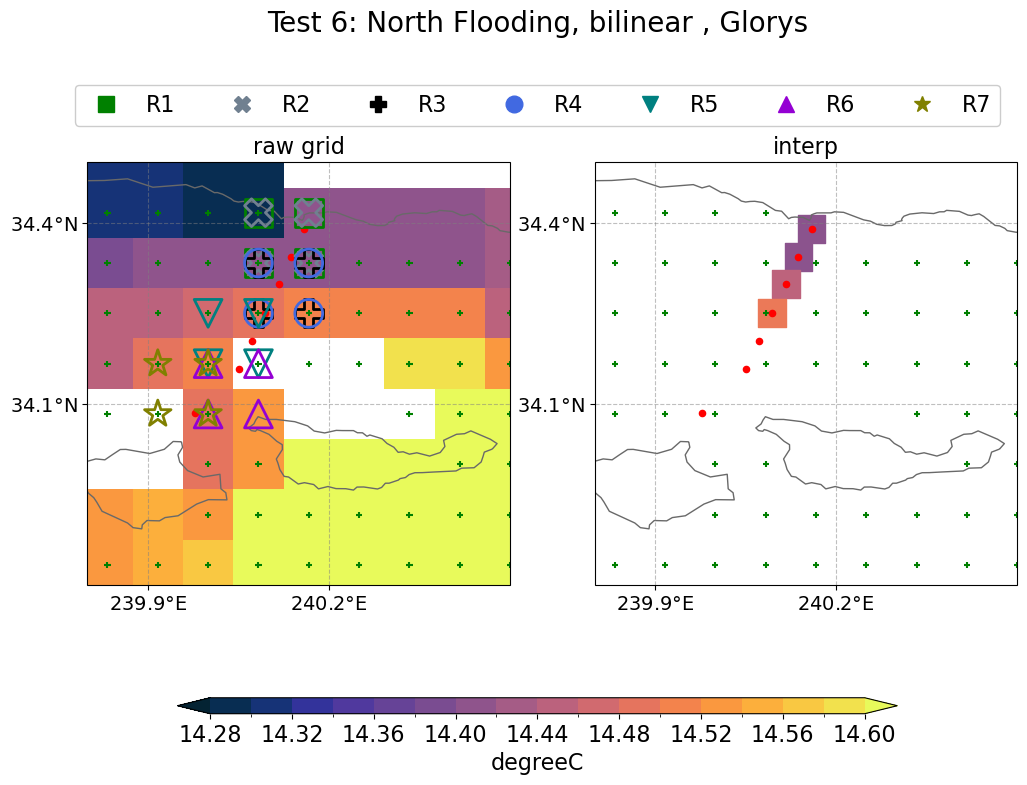

In [80]:
#####
levels = np.arange(14.28,14.6,0.02)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
## 
cc=DGn.plot(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False)
for outj in range(0,len(lonC)):
  data=xr.where(pts_G_bi[outj,:,:]==1,400,np.nan)
  axs[0].scatter(Xg,Yg,s=data, marker=markers[outj],c='None',ec=colors[outj],zorder=50,lw=2.,transform=ccrs.PlateCarree())
axs[0].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DGdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_yticks([34.1,34.4]) 
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
  axs[ix].set_xticks([-120.1,-119.8]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
###
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 6: North Flooding, bilinear , Glorys',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_G_test6.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT test6 NEP

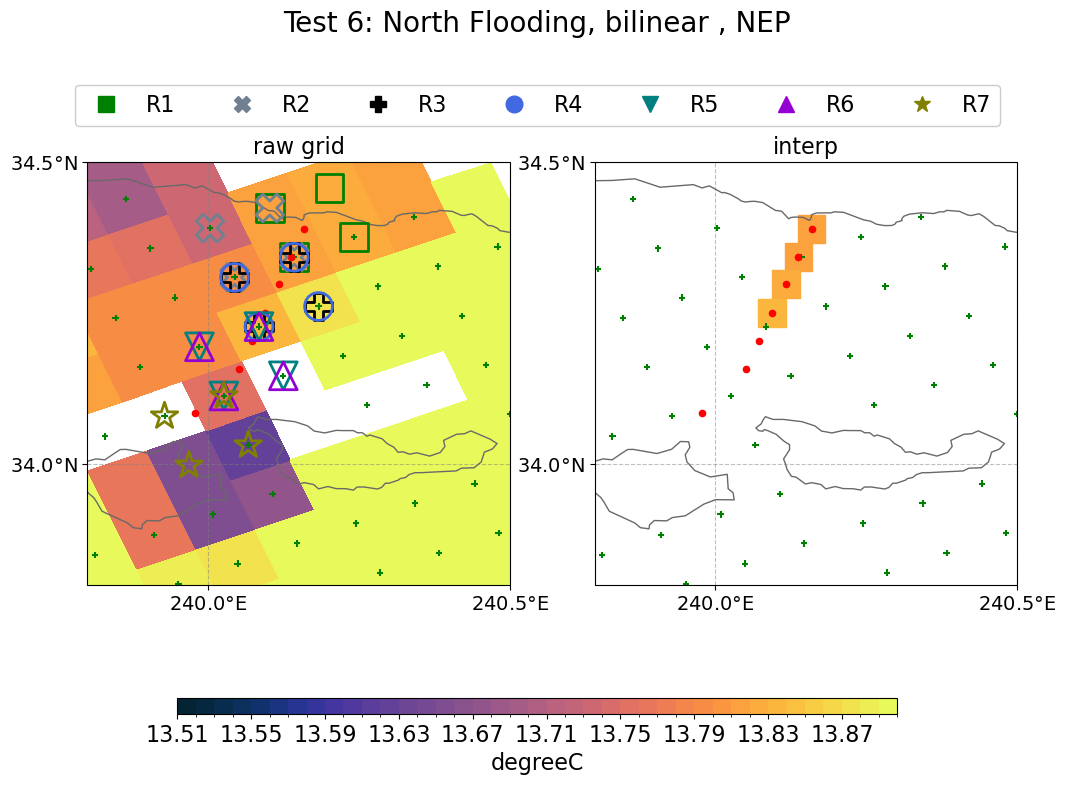

In [81]:
#####
levels = np.arange(13.51,13.9,0.01)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
##########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
for outj in range(0,len(lonC)):
  data=xr.where(pts_N_bi[outj,:,:]==1,400,np.nan)
  axs[0].scatter(DD.lon,DD.lat,s=data, marker=markers[outj],c='None',ec=colors[outj],lw=2.,zorder=50, transform=ccrs.PlateCarree())
cc=axs[0].pcolormesh(DN.longitude.data,DN.latitude.data,DNn.data,cmap=cmap,norm=norm)
axs[0].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DNdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_xticks([-120,-119.5]) 
  axs[ix].set_yticks([34,34.5]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
##
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 6: North Flooding, bilinear , NEP',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_N_test6.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 7: Coastward Flooding, NN Interpolation 
#########

# New Flooding functions lat dependant

In [82]:

def ffill_one_point_coastward_G(arr):
  mask=xr.where(np.isnan(arr),0,1)
  fmaskn=((mask + mask.shift(latitude=1))/2).where(arr.latitude>34.2) 
  fmasks=((mask + mask.shift(latitude=-1))/2).where(arr.latitude<=34.2) 
  farr = xr.where(fmaskn==0.5, arr.shift(latitude=1),arr)
  farr = xr.where(fmasks==0.5, farr.shift(latitude=-1),farr)
  return farr

def ffill_one_point_coastward_N(arr):
  mask=xr.where(np.isnan(arr),0,1)
  fmaskn=((mask + mask.shift(yh=1))/2).where(arr.latitude>34.2) 
  fmasks=((mask + mask.shift(yh=-1))/2).where(arr.latitude<=34.2) 
  farr = xr.where(fmaskn==0.5, arr.shift(yh=1),arr)
  farr = xr.where(fmasks==0.5, farr.shift(yh=-1),farr)
  return farr

In [83]:
# GLORYS
DGns=ffill_one_point_coastward_G(DG)

# NEP
DNns=ffill_one_point_coastward_N(DN)


# Interpolation via xesmf module

In [84]:
### GLORYS
##### Interp H

DGptsi = regridder_G_NN(DGns)
#---
DGdpts =np.zeros((len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['npts'],
        coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[i]=DGptsi[i,i].values

#####
### NEP
##### Interp H

DNptsi = regridder_N_NN(DNns)
#---
DNdpts =np.zeros((len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['npts'],
          coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[i]=DNptsi[i,i].values

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT test7 GLORYS

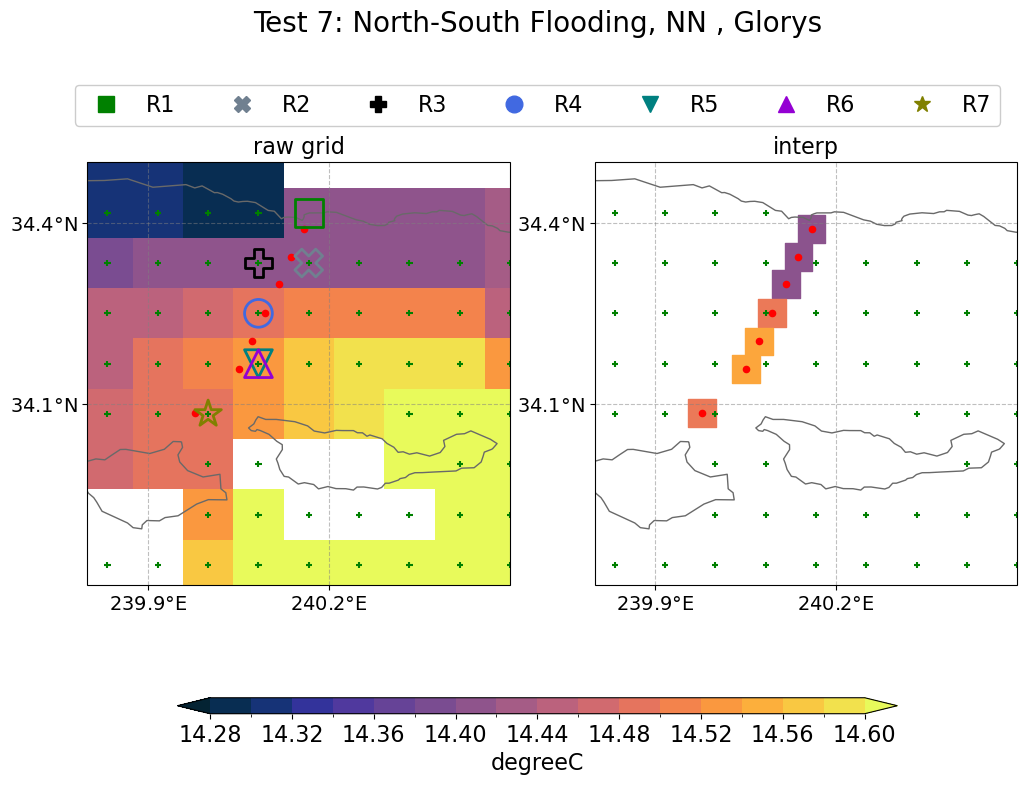

In [85]:
#####
levels = np.arange(14.28,14.6,0.02)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
## 
cc=DGns.plot(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False)
for outj in range(0,len(lonC)):
  data=xr.where(pts_G_NN[outj,:,:]==1,400,np.nan)
  axs[0].scatter(Xg,Yg,s=data, marker=markers[outj],c='None',ec=colors[outj],zorder=50,lw=2.,transform=ccrs.PlateCarree())
axs[0].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DGdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_yticks([34.1,34.4]) 
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
  axs[ix].set_xticks([-120.1,-119.8]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
###
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 7: North-South Flooding, NN , Glorys',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_G_test7.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT test7 NEP

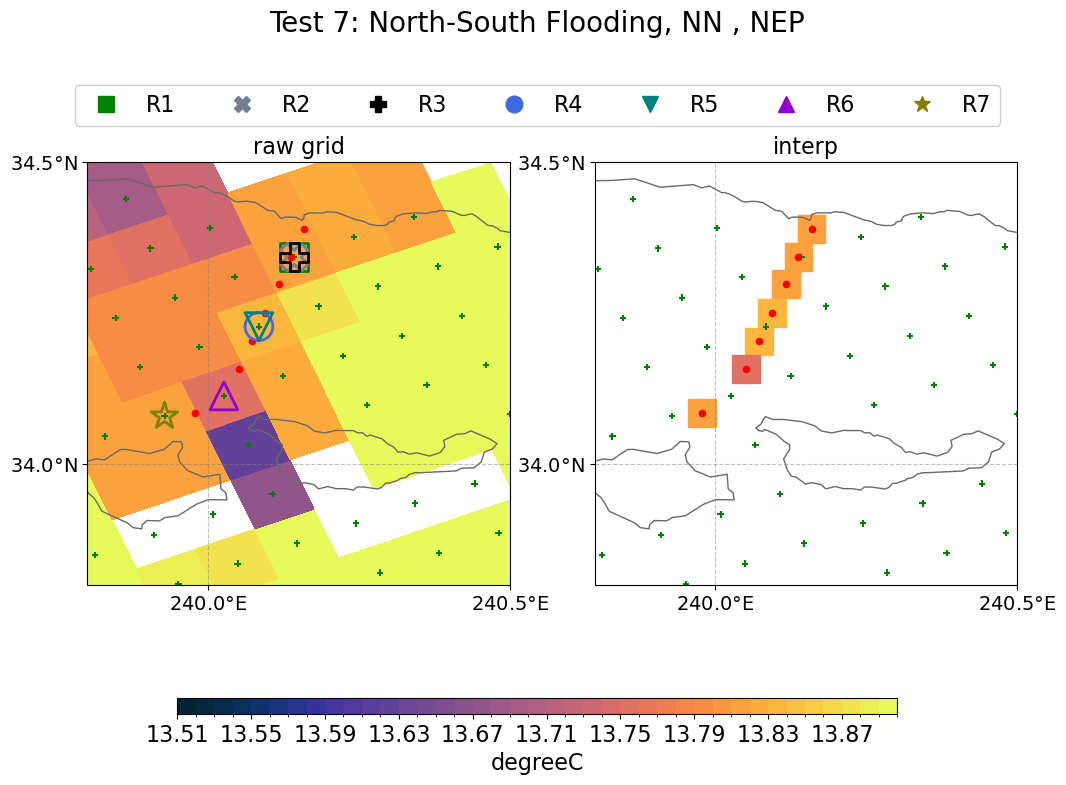

In [86]:
#####
levels = np.arange(13.51,13.9,0.01)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
##########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
for outj in range(0,len(lonC)):
  data=xr.where(pts_N_NN[outj,:,:]==1,400,np.nan)
  axs[0].scatter(DD.lon,DD.lat,s=data, marker=markers[outj],c='None',ec=colors[outj],lw=2.,zorder=50, transform=ccrs.PlateCarree())
cc=axs[0].pcolormesh(DN.longitude.data,DN.latitude.data,DNns.data,cmap=cmap,norm=norm)
axs[0].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DNdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_xticks([-120,-119.5]) 
  axs[ix].set_yticks([34,34.5]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
##
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 7: North-South Flooding, NN , NEP',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_N_test7.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

#########
## test 8: Coastward Flooding, bilinear Interpolation 
#########

# Interpolation via xesmf module

In [87]:
### GLORYS
##### Interp H

DGptsi = regridder_G_bi(DGns)
#---
DGdpts =np.zeros((len(lonCC)))*np.nan
DGdpts=xr.DataArray(DGdpts,dims=['npts'],
        coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DGdpts[i]=DGptsi[i,i].values

#####
### NEP
##### Interp H

DNptsi = regridder_N_bi(DNns)
#---
DNdpts =np.zeros((len(lonCC)))*np.nan
DNdpts=xr.DataArray(DNdpts,dims=['npts'],
          coords={'latC':latC,'lonC':lonC})
for i in range(0,len(lonC)):
  DNdpts[i]=DNptsi[i,i].values

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


# PLOT test8 GLORYS

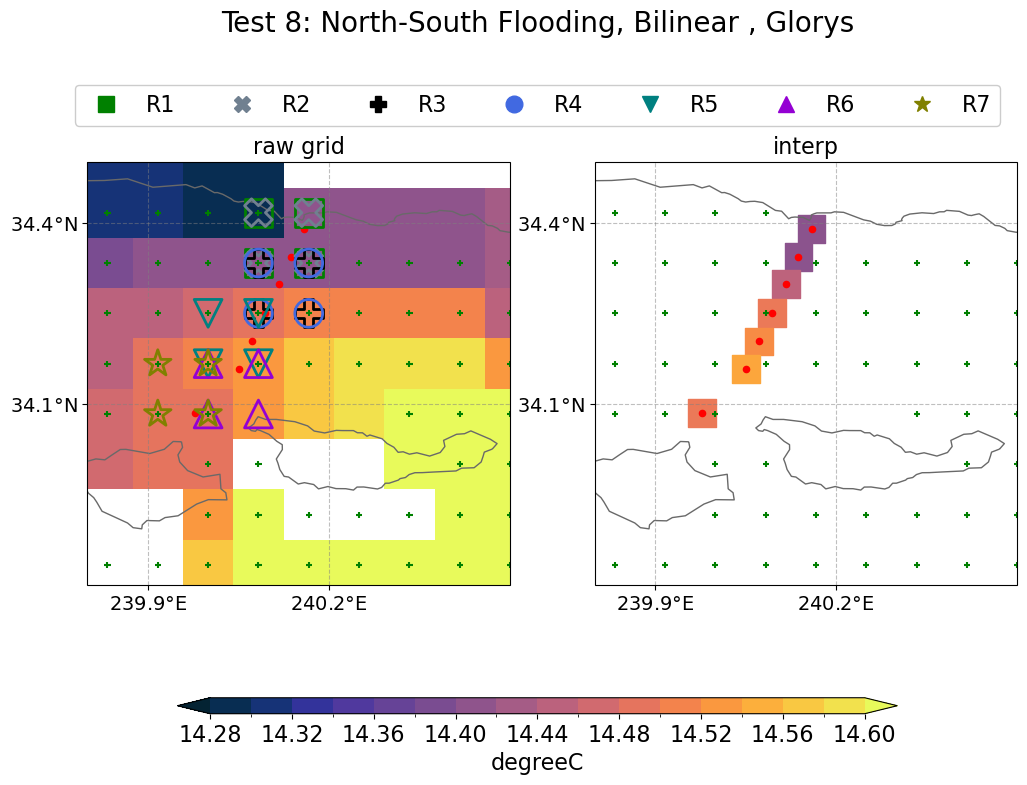

In [88]:
#####
levels = np.arange(14.28,14.6,0.02)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
## 
cc=DGns.plot(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False)
for outj in range(0,len(lonC)):
  data=xr.where(pts_G_bi[outj,:,:]==1,400,np.nan)
  axs[0].scatter(Xg,Yg,s=data, marker=markers[outj],c='None',ec=colors[outj],zorder=50,lw=2.,transform=ccrs.PlateCarree())
axs[0].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DGdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(Xg,Yg,s=landseamaskG*20, marker='+',c='g', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_yticks([34.1,34.4]) 
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
  axs[ix].set_xticks([-120.1,-119.8]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
###
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 8: North-South Flooding, Bilinear , Glorys',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_G_test8.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT test8 NEP

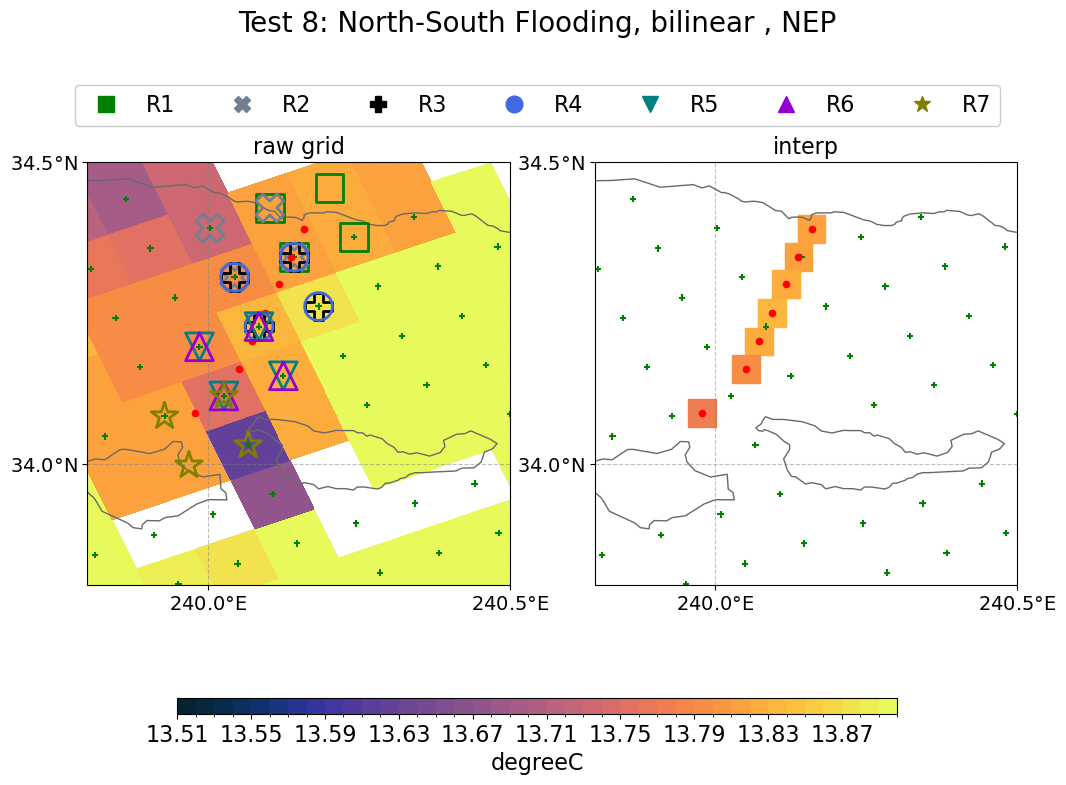

In [89]:
#####
levels = np.arange(13.51,13.9,0.01)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
##########
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8),num=3,clear=True)
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
axs=axs.flatten()
for outj in range(0,len(lonC)):
  data=xr.where(pts_N_bi[outj,:,:]==1,400,np.nan)
  axs[0].scatter(DD.lon,DD.lat,s=data, marker=markers[outj],c='None',ec=colors[outj],lw=2.,zorder=50, transform=ccrs.PlateCarree())
cc=axs[0].pcolormesh(DN.longitude.data,DN.latitude.data,DNns.data,cmap=cmap,norm=norm)
axs[0].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[0].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[0].set_title(f'raw grid',fontsize=16)
## interp
axs[1].scatter(lonC,latC,c=DNdpts.data,cmap=cmap,norm=norm,marker='s',s=400)
axs[1].scatter(DD.lon,DD.lat, color='g', s=landseamaskN*20, marker='+', transform=ccrs.PlateCarree())
for ic in range(len(lonC)):
  axs[1].scatter(lonC[ic],latC[ic],transform=ccrs.PlateCarree(),s=20,c='red')
axs[1].set_title(f'interp',fontsize=16)

for ix in range(0,len(axs)):
  axs[ix].grid()
  axs[ix].set_ylabel(f'')
  axs[ix].set_xlabel(f'')
  axs[ix].coastlines(color='dimgrey')
  axs[ix].set_extent([239.8,240.5,33.8,34.5],ccrs.PlateCarree())
  axs[ix].grid(color='gray', alpha=0.5, linestyle='--')
  axs[ix].set_xticks([-120,-119.5]) 
  axs[ix].set_yticks([34,34.5]) 
  axs[ix].set_xticklabels([f'{ix+360}$\degree$E' for ix in axs[ix].get_xticks()],size=14)
  axs[ix].set_yticklabels([f'{ix}$\degree$N' for ix in axs[ix].get_yticks()],size=14)
##
legend=fig.legend(handles, labels, loc='upper center',markerscale=2,\
        ncol=len(markers),bbox_to_anchor=(0.5,0.9),fontsize=16, framealpha=1)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle('Test 8: North-South Flooding, bilinear , NEP',fontsize=20)
outfile=f'PLOTS/PnB_OBS_interp_N_test8.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')